In [1]:
# /*****************************************
# * 0. 라이브러리와 기본 설정 값 가져오기 *
# *****************************************/

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from arch import arch_model

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import yfinance as yf

np.random.seed(4035)
tf.random.set_seed(4035)

In [2]:
# ================================
#   파생 변수 생성
#   - log return
#   - 22일 realized volatility
#   - lag volatility
# ================================


spx_ticker = "^GSPC"
vix_ticker = "^VIX"
start = "2000-01-01"
end = "2024-12-31"

spx = yf.download(spx_ticker, start=start, end=end)
vix = yf.download(vix_ticker, start=start, end=end)

# print(spx.head())
# print(vix.head())

# 1) 'Close' 레벨에서 첫 번째 컬럼(=그 티커)만 Series로 뽑기
spx_close = spx["Close"].iloc[:, 0]  # (N, ) Series
vix_close = vix["Close"].iloc[:, 0]  # (N, ) Series

# 2) 이름 붙이기
spx_close = spx_close.rename("SPX")
vix_close = vix_close.rename("VIX")

# 3) 옆으로 붙이기
df = pd.concat([spx_close, vix_close], axis=1).dropna()
print(df.head())
print(df.shape)

C:\Users\a\AppData\Local\Temp\ipykernel_32588\2276838148.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx = yf.download(spx_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
C:\Users\a\AppData\Local\Temp\ipykernel_32588\2276838148.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download(vix_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

                    SPX        VIX
Date                              
2000-01-03  1455.219971  24.209999
2000-01-04  1399.420044  27.010000
2000-01-05  1402.109985  26.410000
2000-01-06  1403.449951  25.730000
2000-01-07  1441.469971  21.719999
(6288, 2)


In [3]:
# ================================
# 2. 파생 변수 생성
#    - log return
#    - 22일 realized volatility
#    - lag volatility
# ================================
vol_window = 22
df["ret"] = np.log(df["SPX"] / df["SPX"].shift(1))
df["realized_vol"] = df["ret"].rolling(window=vol_window).std()
df["lag_realized_vol"] = df["realized_vol"].shift(1)
df = df.dropna()
print(df.head())
print(df.isna().sum())
print(df["realized_vol"].describe())

                    SPX        VIX       ret  realized_vol  lag_realized_vol
Date                                                                        
2000-02-04  1424.369995  21.540001 -0.000421      0.013582          0.016031
2000-02-07  1424.239990  22.790001 -0.000091      0.013581          0.013582
2000-02-08  1441.719971  21.250000  0.012198      0.013801          0.013581
2000-02-09  1411.709961  22.900000 -0.021035      0.013346          0.013801
2000-02-10  1416.829956  23.070000  0.003620      0.013117          0.013346
SPX                 0
VIX                 0
ret                 0
realized_vol        0
lag_realized_vol    0
dtype: int64
count    6265.000000
mean        0.010335
std         0.006669
min         0.002164
25%         0.006196
50%         0.008620
75%         0.012603
max         0.060027
Name: realized_vol, dtype: float64


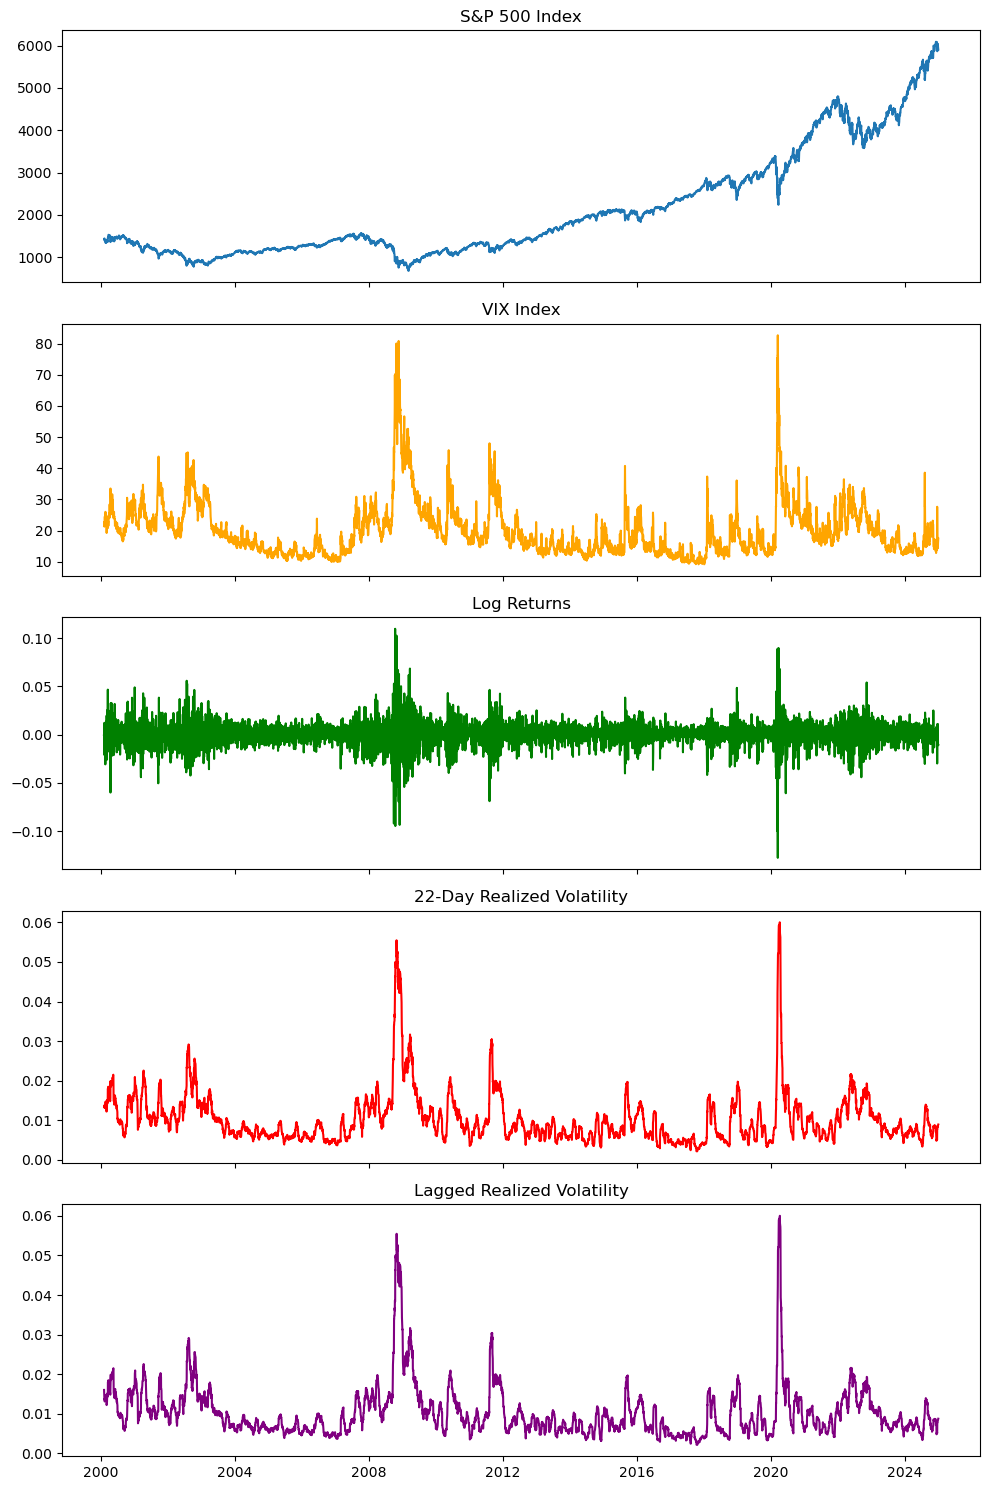

In [4]:
import matplotlib.pyplot as plt

plt.style.use("default")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "white"

fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

axs[0].plot(df.index, df["SPX"])
axs[0].set_title("S&P 500 Index")
axs[1].plot(df.index, df["VIX"], color="orange")
axs[1].set_title("VIX Index")
axs[2].plot(df.index, df["ret"], color="green")
axs[2].set_title("Log Returns")
axs[3].plot(df.index, df["realized_vol"], color="red")
axs[3].set_title("22-Day Realized Volatility")
axs[4].plot(df.index, df["lag_realized_vol"], color="purple")
axs[4].set_title("Lagged Realized Volatility")
plt.tight_layout()
plt.show()

In [5]:
returns = df["ret"].dropna()
dates = returns.index
garch_forecasts = pd.Series(index=dates, dtype=float)

p, q = 2, 2  # GARCH(2,2) 모델 적용
initial_window = 1500  # 약 4년 정도의 기간을 학습으로 사용

if len(returns) <= initial_window + 1:
    raise ValueError(
        f"initial_window={initial_window} 이(가) 너무 큼. "
        f"returns 길이={len(returns)} 확인해서 줄여줘."
    )

print("GARCH is rolling..")
for i in range(initial_window, len(returns) - 1):
    train_data = returns.iloc[:i]

    am = arch_model(
        train_data * 100,
        mean="Zero",
        vol="GARCH",
        p=p,
        q=q,
        dist="normal",
    )
    res = am.fit(disp="off")

    forecast = res.forecast(horizon=1)
    sigma2_t1 = forecast.variance.values[-1, 0]

    garch_forecasts.iloc[i + 1] = np.sqrt(sigma2_t1)

print("GARCH forcast count:", garch_forecasts.notna().sum())

garch_forecasts.name = "garch_vol_pred"

# df에 merge 해서, LSTM feature로 사용 준비
df = df.join(garch_forecasts, how="left")
df = df.dropna()
print("GARCH 예측 merge 후 데이터 크기:", df.shape)
print(df[["ret", "realized_vol", "lag_realized_vol", "garch_vol_pred", "VIX"]].head())

GARCH is rolling..
GARCH forcast count: 4764
GARCH 예측 merge 후 데이터 크기: (4764, 6)
                 ret  realized_vol  lag_realized_vol  garch_vol_pred    VIX
Date                                                                       
2006-01-26  0.007209      0.006985          0.006870        0.740898  12.42
2006-01-27  0.007734      0.007168          0.006985        0.739181  11.97
2006-01-30  0.001144      0.006801          0.007168        0.715838  12.39
2006-01-31 -0.003984      0.006883          0.006801        0.733648  12.95
2006-02-01  0.001858      0.006834          0.006883        0.723744  12.36


# Model 1: Predict Realized Volatility using Only LSTM #

In [6]:
# ================================
# 1. LSTM용 데이터셋 만들기 (leakage-free)
#    - feature: ret, lag_realized_vol
#    - target: realized_vol
#    - ONLY X scaling
# ================================

feature_cols = ["ret", "lag_realized_vol"]
target_col = "realized_vol"
lookback = 22

data = df.copy()

# ===== 1) raw feature, target 생성 =====
X_raw = data[feature_cols].values
y_raw = data[target_col].values.reshape(-1, 1)

# ===== 2) train / val / test split =====
n = len(X_raw)
n_train = int(n * 0.7)
n_val = int(n * 0.15)

X_raw_train = X_raw[:n_train]
X_raw_val = X_raw[n_train : n_train + n_val]
X_raw_test = X_raw[n_train + n_val :]

y_train_raw = y_raw[:n_train]
y_val_raw = y_raw[n_train : n_train + n_val]
y_test_raw = y_raw[n_train + n_val :]


# ===== 3) Feature(X)만 MinMax Scaling (train으로만 fit) =====
scaler_X = MinMaxScaler()
scaler_X.fit(X_raw_train)  # train 데이터만 사용

X_train_scaled = scaler_X.transform(X_raw_train)
X_val_scaled = scaler_X.transform(X_raw_val)
X_test_scaled = scaler_X.transform(X_raw_test)

# y는 scaling 하지 않음
y_train_scaled = y_train_raw
y_val_scaled = y_val_raw
y_test_scaled = y_test_raw


# ===== 4) 각 세트에서 lookback 시퀀스 생성 =====
def create_sequences(X, y, lookback):
    X_list, y_list = [], []
    for i in range(lookback, len(X)):
        X_list.append(X[i - lookback : i])
        y_list.append(y[i, 0])  # y는 scaling 안함
    return np.array(X_list), np.array(y_list)


X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, lookback)


# ===== 5) 결과 출력 =====
print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:  ", X_val.shape, y_val.shape)
print("Test shapes: ", X_test.shape, y_test.shape)

Train shapes: (3312, 22, 2) (3312,)
Val shapes:   (692, 22, 2) (692,)
Test shapes:  (694, 22, 2) (694,)


In [7]:
# ================================
# 2. LSTM 모델 정의 & 학습
# ================================

input_shape = X_train.shape[1:]  # (lookback, n_features)
print("LSTM 입력 형태:", input_shape)
lstm_units = 128
num_layers = 2
dropout_rate = 0.1

model = models.Sequential()
# 첫 번째 LSTM
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=(num_layers > 1),
        input_shape=input_shape,
    )
)
model.add(layers.Dropout(dropout_rate))

# 두 번째 LSTM (num_layers=2 기준)
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=False,
    )
)
model.add(layers.Dropout(dropout_rate))

# 출력층
model.add(layers.Dense(1, activation="softplus"))
# Softplus를 사용함으로써 0 이상으로 나오도록 강제 및 선형적으로 숫자가 커짐으로써 큰 변동성 spike도 잡아내도록

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

print(model.summary())

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=0,
)

LSTM 입력 형태: (22, 2)


c:\Users\a\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 22, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,785 (776.50 KB)

 Trainable params: 198,785 (776.50 KB)

 Non-trainable params: 0 (0.00 B)

None


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
========== Final Results ==========
Test MAE : 0.000824
Test RMSE: 0.001115


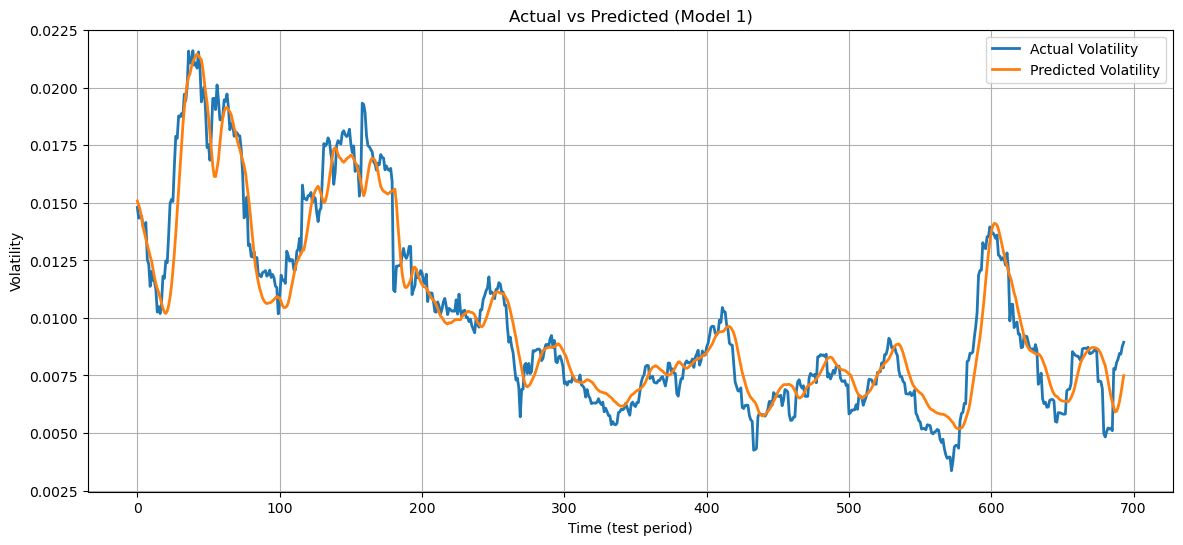

In [8]:
results = {}

# 1) 예측 (이미 실제 단위의 변동성을 바로 예측함)
y_pred_m1 = model.predict(X_test).reshape(-1)  # (N, 1) -> (N,)
y_true = y_test.reshape(-1)  # (N,)

# 2) RMSE / MAE 계산 (스케일링 없이 그대로)
mae = mean_absolute_error(y_true, y_pred_m1)
mse = mean_squared_error(y_true, y_pred_m1)
rmse = np.sqrt(mse)
results["LSTM"] = (mae, rmse)

print("========== Final Results ==========")
print(f"Test MAE : {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Volatility", linewidth=2)
plt.plot(y_pred_m1, label="Predicted Volatility", linewidth=2)
plt.title("Actual vs Predicted (Model 1)")
plt.xlabel("Time (test period)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

# Model 2: Predict Realized Volatility using LSTM + GARCH #

In [9]:
# ================================
# 1. LSTM용 데이터셋 만들기 (leakage-free)
#    - feature: ret, lag_realized_vol, garch_vol_pred
#    - target: realized_vol
#    - ONLY X scaling
# ================================

feature_cols = ["ret", "lag_realized_vol", "garch_vol_pred"]
target_col = "realized_vol"
lookback = 22

data = df.copy()

# ===== 1) raw feature, target 생성 =====
X_raw = data[feature_cols].values
y_raw = data[target_col].values.reshape(-1, 1)

# ===== 2) train / val / test split =====
n = len(X_raw)
n_train = int(n * 0.7)
n_val = int(n * 0.15)

X_raw_train = X_raw[:n_train]
X_raw_val = X_raw[n_train : n_train + n_val]
X_raw_test = X_raw[n_train + n_val :]

y_train_raw = y_raw[:n_train]
y_val_raw = y_raw[n_train : n_train + n_val]
y_test_raw = y_raw[n_train + n_val :]


# ===== 3) Feature(X)만 MinMax Scaling (train으로만 fit) =====
scaler_X = MinMaxScaler()
scaler_X.fit(X_raw_train)  # train 데이터만 사용

X_train_scaled = scaler_X.transform(X_raw_train)
X_val_scaled = scaler_X.transform(X_raw_val)
X_test_scaled = scaler_X.transform(X_raw_test)

# y는 scaling 하지 않음
y_train_scaled = y_train_raw
y_val_scaled = y_val_raw
y_test_scaled = y_test_raw

# ===== 4) 각 세트에서 lookback 시퀀스 생성 =====
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, lookback)

In [10]:
# ================================
# 2. LSTM 모델 정의 & 학습
# ================================

input_shape = X_train.shape[1:]  # (lookback, n_features)
print("LSTM 입력 형태:", input_shape)
lstm_units = 128
num_layers = 2
dropout_rate = 0.1

model = models.Sequential()
# 첫 번째 LSTM
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=(num_layers > 1),
        input_shape=input_shape,
    )
)
model.add(layers.Dropout(dropout_rate))

# 두 번째 LSTM (num_layers=2 기준)
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=False,
    )
)
model.add(layers.Dropout(dropout_rate))

# 출력층
model.add(layers.Dense(1, activation="softplus"))
# Softplus를 사용함으로써 0 이상으로 나오도록 강제 및 선형적으로 숫자가 커짐으로써 큰 변동성 spike도 잡아내도록

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

print(model.summary())

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=0,
)

LSTM 입력 형태: (22, 3)


c:\Users\a\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 22, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,297 (778.50 KB)

 Trainable params: 199,297 (778.50 KB)

 Non-trainable params: 0 (0.00 B)

None


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
========== Final Results ==========
Test MAE : 0.001066
Test RMSE: 0.001426


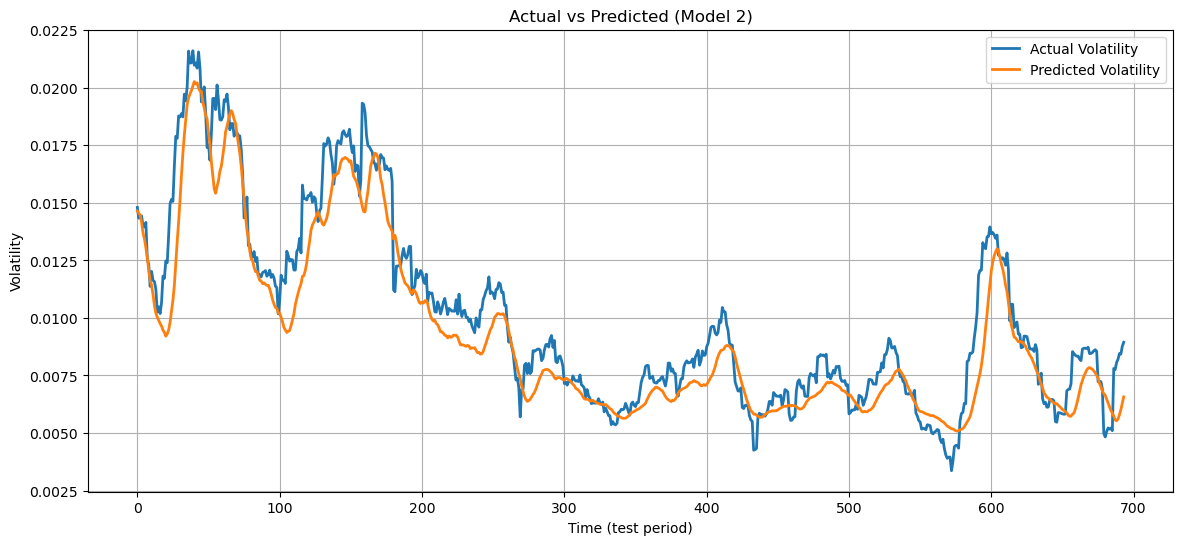

In [11]:
# 1) 예측 (이미 실제 단위의 변동성을 바로 예측함)
y_pred_m2 = model.predict(X_test).reshape(-1)  # (N, 1) -> (N,)
y_true = y_test.reshape(-1)  # (N,)

# 2) RMSE / MAE 계산 (스케일링 없이 그대로)
mae = mean_absolute_error(y_true, y_pred_m2)
mse = mean_squared_error(y_true, y_pred_m2)
rmse = np.sqrt(mse)
results["LSTM-GARCH"] = (mae, rmse)

print("========== Final Results ==========")
print(f"Test MAE : {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Volatility", linewidth=2)
plt.plot(y_pred_m2, label="Predicted Volatility", linewidth=2)
plt.title("Actual vs Predicted (Model 2)")
plt.xlabel("Time (test period)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

# Model 3 : Predict Realized Volatility using LSTM + GARCH + VIX #

In [12]:
# ================================
# 1. LSTM용 데이터셋 만들기 (leakage-free)
#    - feature: ret, lag_realized_vol, garch_vol_pred, VIX
#    - target: realized_vol
#    - ONLY X scaling
# ================================

feature_cols = ["ret", "lag_realized_vol", "garch_vol_pred", "VIX"]
target_col = "realized_vol"
lookback = 22

data = df.copy()

# ===== 1) raw feature, target 생성 =====
X_raw = data[feature_cols].values
y_raw = data[target_col].values.reshape(-1, 1)

# ===== 2) train / val / test split =====
n = len(X_raw)
n_train = int(n * 0.7)
n_val = int(n * 0.15)

X_raw_train = X_raw[:n_train]
X_raw_val = X_raw[n_train : n_train + n_val]
X_raw_test = X_raw[n_train + n_val :]

y_train_raw = y_raw[:n_train]
y_val_raw = y_raw[n_train : n_train + n_val]
y_test_raw = y_raw[n_train + n_val :]


# ===== 3) Feature(X)만 MinMax Scaling (train으로만 fit) =====
scaler_X = MinMaxScaler()
scaler_X.fit(X_raw_train)  # train 데이터만 사용

X_train_scaled = scaler_X.transform(X_raw_train)
X_val_scaled = scaler_X.transform(X_raw_val)
X_test_scaled = scaler_X.transform(X_raw_test)

# y는 scaling 하지 않음
y_train_scaled = y_train_raw
y_val_scaled = y_val_raw
y_test_scaled = y_test_raw

# ===== 4) 각 세트에서 lookback 시퀀스 생성 =====
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled, lookback)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, lookback)

In [13]:
# ================================
# 2. LSTM 모델 정의 & 학습
# ================================

input_shape = X_train.shape[1:]  # (lookback, n_features)
print("LSTM 입력 형태:", input_shape)
lstm_units = 128
num_layers = 2
dropout_rate = 0.1

model = models.Sequential()
# 첫 번째 LSTM
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=(num_layers > 1),
        input_shape=input_shape,
    )
)
model.add(layers.Dropout(dropout_rate))

# 두 번째 LSTM (num_layers=2 기준)
model.add(
    layers.LSTM(
        lstm_units,
        activation="tanh",
        return_sequences=False,
    )
)
model.add(layers.Dropout(dropout_rate))

# 출력층
model.add(layers.Dense(1, activation="softplus"))
# Softplus를 사용함으로써 0 이상으로 나오도록 강제 및 선형적으로 숫자가 커짐으로써 큰 변동성 spike도 잡아내도록

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

print(model.summary())

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=0,
)

LSTM 입력 형태: (22, 4)


c:\Users\a\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 22, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,809 (780.50 KB)

 Trainable params: 199,809 (780.50 KB)

 Non-trainable params: 0 (0.00 B)

None


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
========== Final Results ==========
Test MAE : 0.000808
Test RMSE: 0.001058


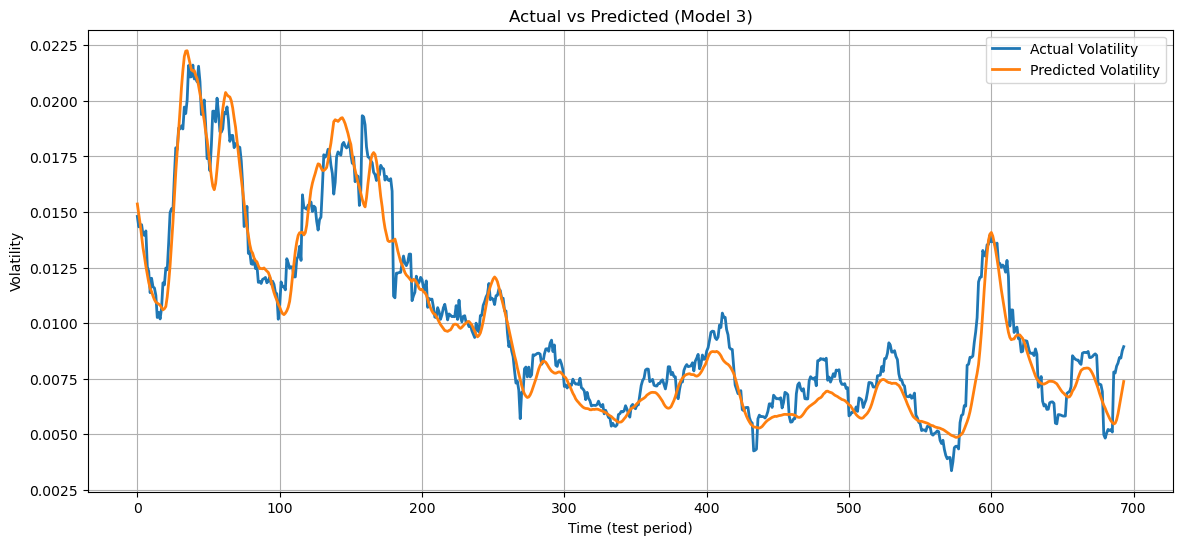

In [14]:
# 1) 예측 (이미 실제 단위의 변동성을 바로 예측함)
y_pred_m3 = model.predict(X_test).reshape(-1)  # (N, 1) -> (N,)
y_true = y_test.reshape(-1)  # (N,)

# 2) RMSE / MAE 계산 (스케일링 없이 그대로)
mae = mean_absolute_error(y_true, y_pred_m3)
mse = mean_squared_error(y_true, y_pred_m3)
rmse = np.sqrt(mse)
results["Hybrid+VIX"] = (mae, rmse)

print("========== Final Results ==========")
print(f"Test MAE : {mae:.6f}")
print(f"Test RMSE: {rmse:.6f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Volatility", linewidth=2)
plt.plot(y_pred_m3, label="Predicted Volatility", linewidth=2)
plt.title("Actual vs Predicted (Model 3)")
plt.xlabel("Time (test period)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

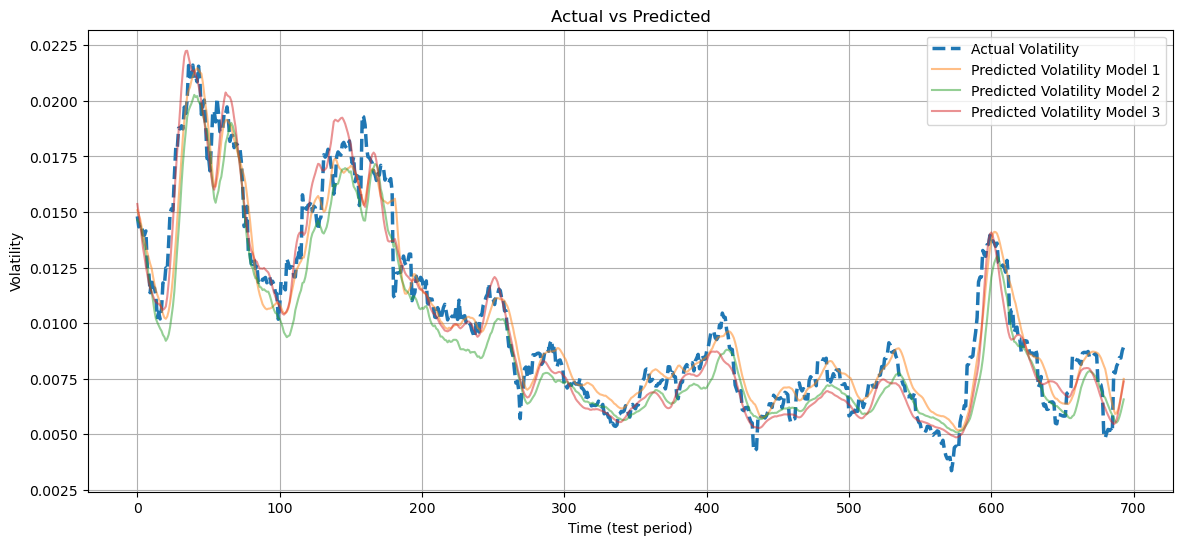

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label="Actual Volatility", linewidth=2.5, linestyle="--")  # 점선 설정
plt.plot(y_pred_m1, label="Predicted Volatility Model 1", linewidth=1.5, alpha=0.5)
plt.plot(y_pred_m2, label="Predicted Volatility Model 2", linewidth=1.5, alpha=0.5)
plt.plot(y_pred_m3, label="Predicted Volatility Model 3", linewidth=1.5, alpha=0.5)

plt.title("Actual vs Predicted")
plt.xlabel("Time (test period)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
result_table = pd.DataFrame(results, index=["MAE", "RMSE"]).T
print(result_table)

                 MAE      RMSE
LSTM        0.000824  0.001115
LSTM-GARCH  0.001066  0.001426
Hybrid+VIX  0.000808  0.001058


In [16]:
preds = pd.DataFrame(
    {"LSTM": y_pred_m1, "LSTM_GARCH": y_pred_m2, "Hybrid_VIX": y_pred_m3}
)

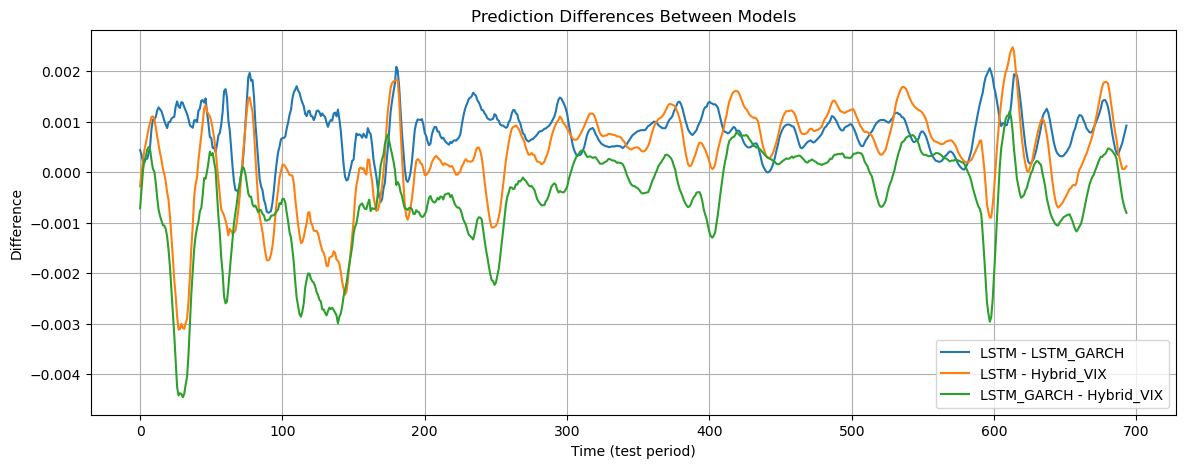

In [20]:
plt.figure(figsize=(14, 5))

# 각 차이를 한 그래프에 plot
plt.plot(preds["LSTM"] - preds["LSTM_GARCH"], label="LSTM - LSTM_GARCH")
plt.plot(preds["LSTM"] - preds["Hybrid_VIX"], label="LSTM - Hybrid_VIX")
plt.plot(preds["LSTM_GARCH"] - preds["Hybrid_VIX"], label="LSTM_GARCH - Hybrid_VIX")

plt.title("Prediction Differences Between Models")
plt.xlabel("Time (test period)")
plt.ylabel("Difference")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 0.98이상 이면 거의 동일한 예측을 하고 있음
# LSTM 모델이 실제로 target이 갖는 구조적 패턴(= mean reversion + persistence)을 정확히 반영하고 있다.
# 추가 feature가 signal을 강화하지 못했다.
# LSTM이 AR(1)에 가까운 mapping을 배운 것.

print(preds.corr())

                LSTM  LSTM_GARCH  Hybrid_VIX
LSTM        1.000000    0.992460    0.980575
LSTM_GARCH  0.992460    1.000000    0.979924
Hybrid_VIX  0.980575    0.979924    1.000000


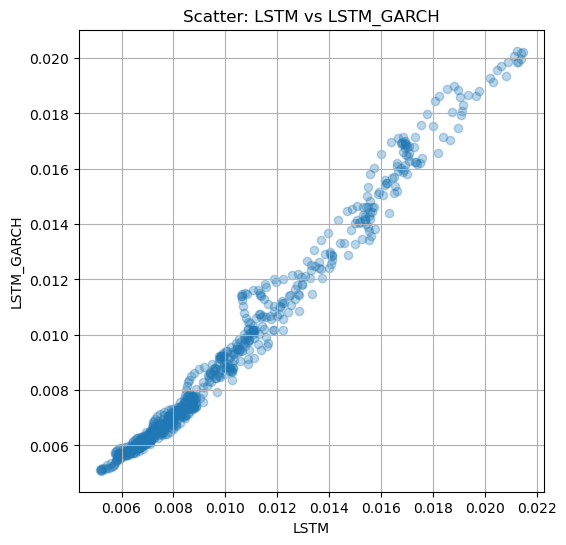

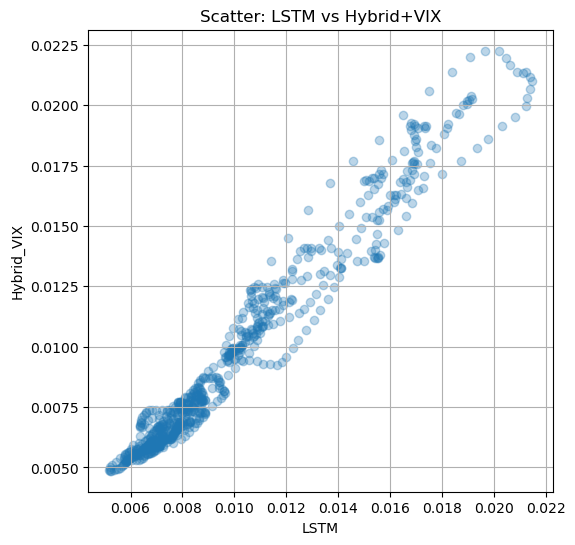

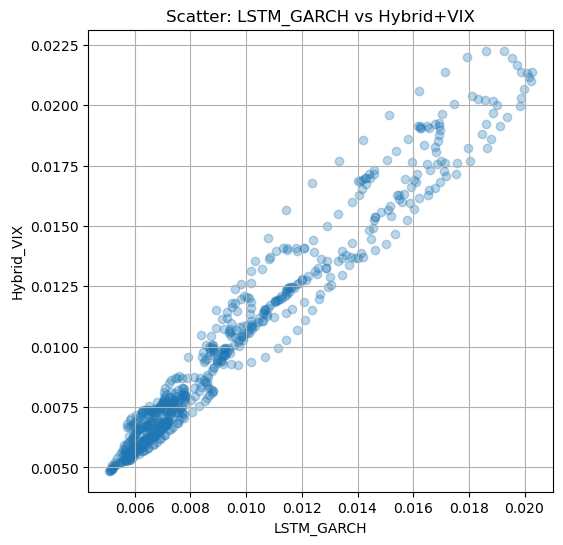

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(preds["LSTM"], preds["LSTM_GARCH"], alpha=0.3)
plt.xlabel("LSTM")
plt.ylabel("LSTM_GARCH")
plt.title("Scatter: LSTM vs LSTM_GARCH")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(preds["LSTM"], preds["Hybrid_VIX"], alpha=0.3)
plt.xlabel("LSTM")
plt.ylabel("Hybrid_VIX")
plt.title("Scatter: LSTM vs Hybrid+VIX")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(preds["LSTM_GARCH"], preds["Hybrid_VIX"], alpha=0.3)
plt.xlabel("LSTM_GARCH")
plt.ylabel("Hybrid_VIX")
plt.title("Scatter: LSTM_GARCH vs Hybrid+VIX")
plt.grid(True)
plt.show()